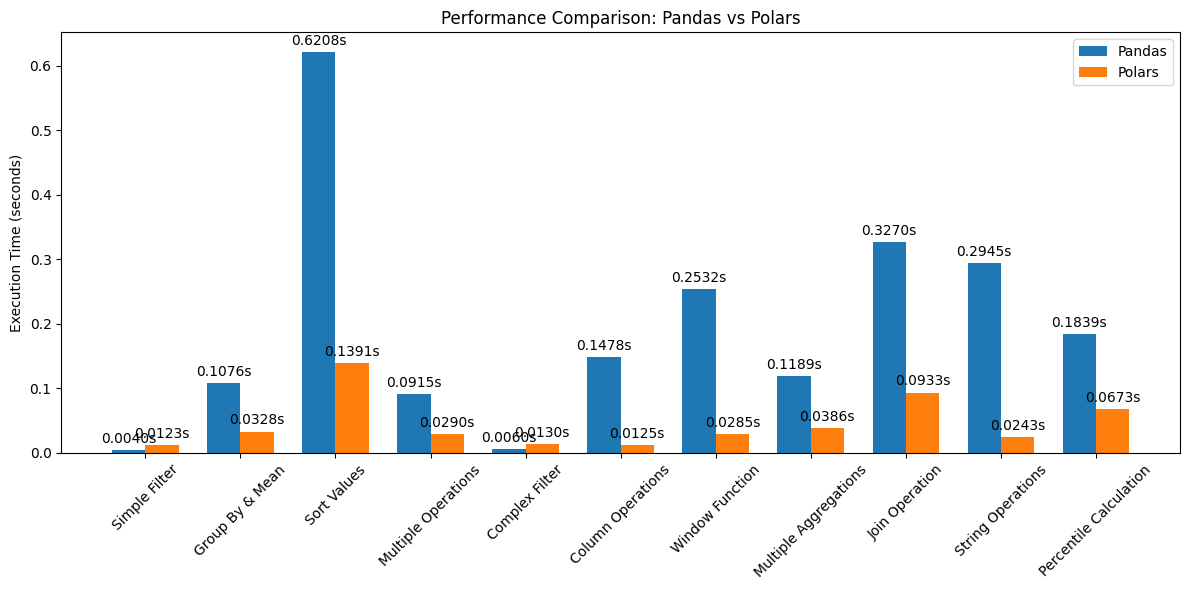

In [4]:
import polars as pl
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np

# Read the data
pandas_df = pd.read_csv('datasets/health.csv')
polars_df = pl.read_csv('datasets/health.csv')

pandas_df = pandas_df.rename(columns={
    'Prevalence Rate (%)': 'Prevalence Rate',
    'Incidence Rate (%)': 'Incidence Rate',
    'Mortality Rate (%)': 'Mortality Rate',
    'Healthcare Access (%)': 'Healthcare Access',
    'Recovery Rate (%)': 'Recovery Rate',
    'Urbanization Rate (%)': 'Urbanization Rate',
    'Improvement in 5 Years (%)': 'Improvement in 5 Years'
})

polars_df = polars_df.rename({
    'Prevalence Rate (%)': 'Prevalence Rate',
    'Incidence Rate (%)': 'Incidence Rate',
    'Mortality Rate (%)': 'Mortality Rate',
    'Healthcare Access (%)': 'Healthcare Access',
    'Recovery Rate (%)': 'Recovery Rate',
    'Urbanization Rate (%)': 'Urbanization Rate',
    'Improvement in 5 Years (%)': 'Improvement in 5 Years'
})

# List of operations to test
operations = [
    ('Simple Filter', 
     lambda pdf: pdf[pdf['Prevalence Rate'] > 50],
     lambda pldf: pldf.filter(pl.col('Prevalence Rate') > 50)),
    
    ('Group By & Mean', 
     lambda pdf: pdf.groupby('Country')['Prevalence Rate'].mean(),
     lambda pldf: pldf.group_by('Country').agg(pl.col('Prevalence Rate').mean())),
    
    ('Sort Values', 
     lambda pdf: pdf.sort_values('Prevalence Rate', ascending=False),
     lambda pldf: pldf.sort('Prevalence Rate', descending=True)),
    
    ('Multiple Operations',
     lambda pdf: pdf.groupby('Country').agg({'Prevalence Rate': 'mean', 'Mortality Rate': 'sum'}).sort_values('Prevalence Rate'),
     lambda pldf: pldf.group_by('Country').agg([
         pl.col('Prevalence Rate').mean(),
         pl.col('Mortality Rate').sum()
     ]).sort('Prevalence Rate')),
    
    ('Complex Filter', 
     lambda pdf: pdf[(pdf['Prevalence Rate'] > 50) & (pdf['Mortality Rate'] < 30)],
     lambda pldf: pldf.filter((pl.col('Prevalence Rate') > 50) & (pl.col('Mortality Rate') < 30))),
    
    ('Column Operations',
     lambda pdf: pdf.assign(Risk_Score=pdf['Prevalence Rate'] * pdf['Mortality Rate'] / 100),
     lambda pldf: pldf.with_columns((pl.col('Prevalence Rate') * pl.col('Mortality Rate') / 100).alias('Risk_Score'))),
    
    ('Window Function',
     lambda pdf: pdf.assign(Avg_Prevalence=pdf.groupby('Country')['Prevalence Rate'].transform('mean')),
     lambda pldf: pldf.with_columns(pl.col('Prevalence Rate').mean().over('Country').alias('Avg_Prevalence'))),
    
    ('Multiple Aggregations',
     lambda pdf: pdf.groupby('Country').agg({
         'Prevalence Rate': ['mean', 'min', 'max'],
         'Mortality Rate': ['mean', 'min', 'max']}),
     lambda pldf: pldf.group_by('Country').agg([
         pl.col('Prevalence Rate').mean().alias('Prevalence_mean'),
         pl.col('Prevalence Rate').min().alias('Prevalence_min'),
         pl.col('Prevalence Rate').max().alias('Prevalence_max'),
         pl.col('Mortality Rate').mean().alias('Mortality_mean'),
         pl.col('Mortality Rate').min().alias('Mortality_min'),
         pl.col('Mortality Rate').max().alias('Mortality_max')
     ])),
    
    ('Join Operation',
     lambda pdf: pdf.merge(pdf.groupby('Country')['Prevalence Rate'].mean().reset_index(), 
                          on='Country', 
                          suffixes=('', '_country_avg')),
     lambda pldf: pldf.join(
         pldf.group_by('Country').agg(pl.col('Prevalence Rate').mean().alias('Prevalence_country_avg')),
         on='Country'
     )),
    
    ('String Operations',
     lambda pdf: pdf.assign(Country_Upper=pdf['Country'].str.upper()),
     lambda pldf: pldf.with_columns(pl.col('Country').str.to_uppercase().alias('Country_Upper'))),
    
    
    ('Percentile Calculation',
     lambda pdf: pdf.groupby('Country')['Prevalence Rate'].quantile(0.75),
     lambda pldf: pldf.group_by('Country').agg(pl.col('Prevalence Rate').quantile(0.75).alias('percentile_75')))
]

# Lists to store results
pandas_times = []
polars_times = []
operation_names = []

# Measure execution times
for name, pandas_op, polars_op in operations:
    # Pandas timing
    start_time = time.time()
    pandas_op(pandas_df)
    pandas_time = time.time() - start_time
    pandas_times.append(pandas_time)
    
    # Polars timing
    start_time = time.time()
    polars_op(polars_df)
    polars_time = time.time() - start_time
    polars_times.append(polars_time)
    
    operation_names.append(name)

# Create the bar plot
x = np.arange(len(operation_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, pandas_times, width, label='Pandas')
rects2 = ax.bar(x + width/2, polars_times, width, label='Polars')

# Customize the plot
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Performance Comparison: Pandas vs Polars')
ax.set_xticks(x)
ax.set_xticklabels(operation_names, rotation=45)
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}s',
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [3]:
# After loading the dataframes, add:
print("Pandas columns:", pandas_df.columns.tolist())
print("Polars columns:", polars_df.columns)

Pandas columns: ['Country', 'Year', 'Disease Name', 'Disease Category', 'Prevalence Rate (%)', 'Incidence Rate (%)', 'Mortality Rate (%)', 'Age Group', 'Gender', 'Population Affected', 'Healthcare Access (%)', 'Doctors per 1000', 'Hospital Beds per 1000', 'Treatment Type', 'Average Treatment Cost (USD)', 'Availability of Vaccines/Treatment', 'Recovery Rate (%)', 'DALYs', 'Improvement in 5 Years (%)', 'Per Capita Income (USD)', 'Education Index', 'Urbanization Rate (%)']
Polars columns: ['Country', 'Year', 'Disease Name', 'Disease Category', 'Prevalence Rate (%)', 'Incidence Rate (%)', 'Mortality Rate (%)', 'Age Group', 'Gender', 'Population Affected', 'Healthcare Access (%)', 'Doctors per 1000', 'Hospital Beds per 1000', 'Treatment Type', 'Average Treatment Cost (USD)', 'Availability of Vaccines/Treatment', 'Recovery Rate (%)', 'DALYs', 'Improvement in 5 Years (%)', 'Per Capita Income (USD)', 'Education Index', 'Urbanization Rate (%)']
